In [1]:
%%javascript
require.config({ 
    paths: { 
    d3: 'https://d3js.org/d3.v7.min'
}});

require(["d3"], function(d3) {
    window.d3 = d3;
});

<IPython.core.display.Javascript object>

In [2]:
%reset -f
#import sparg_with_inf as sparg
import sys
sys.path.append("/home/puneeth/UofT/Projects/SpARG Project/sparg_github/sparg/")
import sparg as sparg
import tskit
import msprime
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Qt5Agg')
import tskit_arg_visualizer

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations



def average_dispersal_treewise(ts, locations_of_nodes):
    branch_lengths = ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]
    child_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.child) ))
    parent_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.parent) ))
    branch_distances = parent_locations - child_locations 
    ts_trees = ts.aslist()
    dispersal_rate = []
    average_dispersal_rate = []
    for ts_tree in ts_trees:     
        edge_ind = ts_tree.edge_array[ts_tree.edge_array>-1]
        tree_branch_lengths = branch_lengths[edge_ind]
        tree_branch_distances = branch_distances[edge_ind]
        tree_dispersal_rate = [ np.matmul( np.transpose([tree_branch_distances[i]]),[tree_branch_distances[i]] )/tree_branch_lengths[i] for i in range(len(tree_branch_distances)) ]
        tree_dispersal_rate = np.sum(np.array(tree_dispersal_rate), axis=0)/ts.num_samples   
        dispersal_rate += [tree_dispersal_rate]
        average_dispersal_rate += [ np.average(np.array(dispersal_rate), axis=0) ]
    return dispersal_rate, average_dispersal_rate 

In [12]:
ts = tskit.load("slim_0.25rep1sigma.trees")
nsamples = 10
keep_nodes = list(np.random.choice(ts.samples(),nsamples, replace=False))
    
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_filtered,10000)
FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
#print(ts_chopped.draw_text())
path_matrix = FullARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(FullARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = FullARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)
sigma_squared = np.array([[0.25,0.0],[0.0,0.25]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

replicates = 100 
dispersal_rates_x = []
dispersal_rates_y = []

for rep in range(replicates) : 
    print(rep)
    simulated = np.random.multivariate_normal(mean = np.array([0 for x in range(2*nsamples) ]), cov =sample_covariance_matrix )
    location_of_individuals = {} 
    for sample in range(nsamples): 
        location_of_individuals[ ts_chopped.tables.nodes.individual[sample] ] = np.array([simulated[2*sample],simulated[2*sample+1]])

    FullARG_Brownian = sparg.SpatialARG(ts=ts_chopped,locations_of_individuals=location_of_individuals, dimensions=2, verbose=False)
    disp_mat = FullARG_Brownian.dispersal_rate_matrix
    print(disp_mat)
    dispersal_rates_x += [disp_mat[0][0]]
    dispersal_rates_y += [disp_mat[1][1]]
    
plt.hist(dispersal_rates_x)
plt.axvline(x = sigma_squared[0][0], color = 'black', linestyle = 'dashed' )
plt.show() 

plt.hist(dispersal_rates_y)
plt.axvline(x = sigma_squared[1][1], color = 'black', linestyle = 'dashed' )
plt.show() 


"""
locations_of_path_starts, locations_of_samples = FullARG.expand_locations() 
print(sum(np.matmul(P, np.array(list(locations_of_samples.values()))) - locations_of_path_starts))
print(FullARG.root_locations)

d3arg = tskit_arg_visualizer.D3ARG(ts=ts_chopped)
d3arg.draw(
    width=750,
    height=750,
    edge_type="ortho"
)

"""


0
[[0.32601482 0.04177908]
 [0.04177908 0.25340725]]
1
[[0.42643017 0.00950578]
 [0.00950578 0.32527845]]
2
[[ 0.31159019 -0.03323202]
 [-0.03323202  0.14186608]]
3


KeyboardInterrupt: 

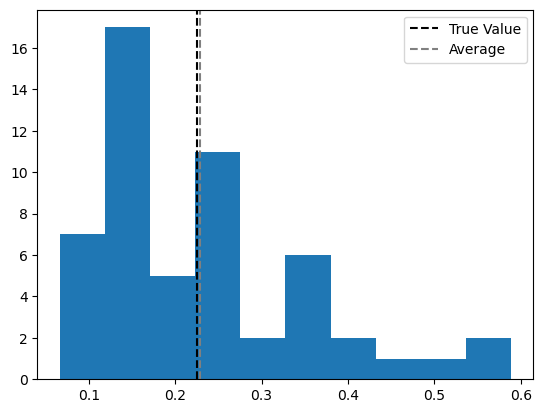

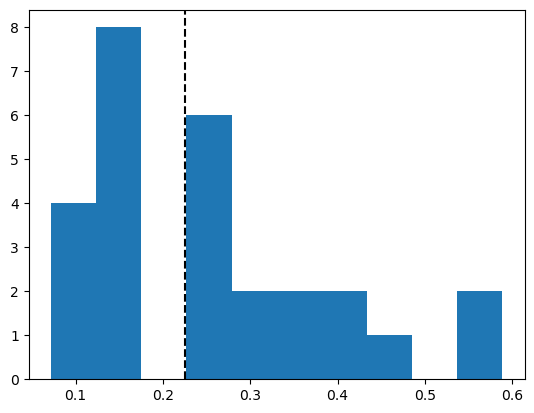

In [13]:
plt.hist(np.array(dispersal_rates_x+dispersal_rates_y),bins = 10)
plt.axvline(x = sigma_squared[0][0], color = 'black', linestyle = 'dashed', label = 'True Value' )
plt.axvline(x = np.average(dispersal_rates_x+dispersal_rates_y), color = 'grey', linestyle = 'dashed', label = 'Average' )
plt.legend()
plt.show() 

plt.hist(dispersal_rates_y,bins=10)
plt.axvline(x = sigma_squared[1][1]*0.9, color = 'black', linestyle = 'dashed' )
plt.show() 


In [37]:
ts = tskit.load("slim_0.25rep1sigma.trees")
sd = 4
np.random.seed(sd)
keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_filtered,10000)

d = 0 
d_sqrt = 0
n = 0

edges_done = []
for edge in ts_chopped.tables.edges:
    if edgeid%100 == 0 :
        print(edgeid)
    parent_individual = ts_chopped.tables.nodes[edge.parent].individual
    child_individual = ts_chopped.tables.nodes[edge.child].individual
    if (child_individual,parent_individual) not in edges_done: 
        parent_time = ts_chopped.tables.nodes[edge.parent].time
        child_time = ts_chopped.tables.nodes[edge.child].time
        
        edges_done += [ (child_individual,parent_individual) ]
        
        parent_location = ts_chopped.tables.individuals[parent_individual].location
        child_location = ts_chopped.tables.individuals[child_individual].location
        
        d += np.array(parent_location - child_location)**2/(parent_time-child_time)
        d_sqrt += np.sqrt(sum(np.array(parent_location - child_location)**2))/(parent_time-child_time)
        n += 1
print(d/float(n))
print(d_sqrt/float(n))


[0.33732554 0.32235422 0.        ]
0.14064304450511894
